In [131]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym


In [132]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [133]:
filename = "EURUSD_M1_2023.csv"


df1 = pd.read_csv("./data_saved/EURUSD_M1_2021.csv")
df2 = pd.read_csv("./data_saved/EURUSD_M1_2022.csv")

concatenated_df = pd.concat([df1, df2], axis=0)
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df['timestamp'] = pd.to_datetime(concatenated_df['timestamp']) 

#timestamp as index
concatenated_df.set_index('timestamp', inplace=True)
data = concatenated_df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
data = data.dropna(axis=0)
data.reset_index(drop=True, inplace=True)

print(data.head(10))
print(data.describe())

            timestamp     open     high      low    close
0 2021-01-03 17:00:00  1.22387  1.22420  1.22296  1.22315
1 2021-01-03 17:15:00  1.22324  1.22387  1.22324  1.22361
2 2021-01-03 17:30:00  1.22367  1.22400  1.22325  1.22339
3 2021-01-03 17:45:00  1.22340  1.22348  1.22325  1.22325
4 2021-01-03 18:00:00  1.22331  1.22412  1.22304  1.22369
5 2021-01-03 18:15:00  1.22392  1.22406  1.22336  1.22383
6 2021-01-03 18:30:00  1.22397  1.22481  1.22394  1.22458
7 2021-01-03 18:45:00  1.22470  1.22527  1.22435  1.22486
8 2021-01-03 19:00:00  1.22499  1.22499  1.22426  1.22449
9 2021-01-03 19:15:00  1.22454  1.22474  1.22406  1.22445
                           timestamp          open          high  \
count                          49831  49831.000000  49831.000000   
mean   2022-01-02 01:36:32.665208576      1.117939      1.118306   
min              2021-01-03 17:00:00      0.953900      0.955170   
25%              2021-07-05 08:37:30      1.052315      1.052730   
50%              2022-

In [134]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
data_tensor.shape

torch.Size([1, 49831, 1])

In [135]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(Enum):
    Short = 0
    Long = 1
    Hold = 2

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class CustomTradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        # super().__init__(df, window_size, render_mode)

        self.trade_fee = 0.0003  # unit
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.render_mode = render_mode
        self._done = False
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        # logging.debug("Trading Env reset.")
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1

        self._position = Positions.Short

        # self._position = self.get_position(seed)
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation(self._done)
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        # logging.debug("Trading Env step.")
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True
        
        #update position according with action
        if action == Actions.Buy.value:
            self._position = Positions.Long
        elif action == Actions.Sell.value:
            self._position = Positions.Short
        else:
            self._position = Positions.Hold
            
        
        trade = False
        if action == Actions.Buy.value  or action == Actions.Sell.value:
            trade = True

        step_reward  = 0.0
        
        ### Last trade tick
        self._last_trade_tick = self._current_tick - 1
        if trade:
            self._position_history.append(self._position)

        ## End in last tick
        if self._current_tick == self._end_tick:
            self._done = True
        
        ## Calculate step rewards
        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        self._total_profit += (step_reward - self.trade_fee)

        if self.render_mode == 'human':
            self._render_frame()

        observation = self._get_observation(self._done)
        info = self._get_info()
        self._update_history(info)

        return observation, step_reward, self._done, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self, done):
        if done:
            return [self.prices[self._current_tick], self._total_reward]
        return [self.prices[self._current_tick + 1], self._total_reward]

    def _update_history(self, info):
        # logging.debug("Trading Env uodate history.")
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):
        # logging.debug("Trading Env Render.")

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        # logging.debug("Trading Env render all.")
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        prices = self.df.loc[:, 'close'].to_numpy()
        
        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        step_reward = 0  # pip
        trade = False
        if self._position == Positions.Short or self._position == Positions.Long:
            trade = True
        

        if not trade and self._position == Positions.Hold:
            step_reward =  -0.5
        

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            
            if self._position == Positions.Short:
                step_reward += -price_diff * 10000
            elif self._position == Positions.Long:
                step_reward += price_diff * 10000

        return step_reward



In [136]:
window_size = 2
# start_index = window_size
# end_index = len(data)

env  = CustomTradingEnv(
    df= data,
    window_size=window_size
)

data.shape

(49831, 5)

In [137]:
class DQNLSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(DQNLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Input shape of LSTM layer should be (batch_size, seq_len, input_size)
        # Assuming batch size is 1 for reinforcement learning
        x, _ = self.lstm(x.unsqueeze(0))
        x = x.view(-1, self.lstm.hidden_size)  # Reshape to (batch_size, hidden_dim)
        x = self.fc(x)
        return x

In [138]:
def epsilon_greedy_policy(model, epsilon, num_actions, device):
    def policy_fn(state_info):
         # Extract the array from the tuple if needed
        state_array = state_info[0] if isinstance(state_info, tuple) else state_info 
        state_tensor = torch.tensor(state_array, dtype=torch.float32, device=device)

        with torch.no_grad():
            q_values = model(state_tensor)
            
        if q_values.numel() == 0:  # Check if q_values tensor is empty
            return np.random.choice(num_actions)
        else:
            q_values_cpu = q_values.cpu()
            return torch.argmax(q_values_cpu).item()
    return policy_fn

In [139]:
def train_dqn(env, model, target_model, optimizer, gamma, batch_size, device, epsilon):
    state_info = env.reset()  # Ensure env.reset() returns a tuple (state, info) or just the state
    episode_reward = 0
    done = False
    
    while not done:
        action = epsilon_greedy_policy(model, epsilon, env.action_space.n, device)(state_info)
        step_result = env.step(action)
        next_state, reward, done, truncate, info = step_result[:5]  # Extract the first four values
        print(info)
        episode_reward += reward
        
        done = done or truncate
        state_info = next_state  # Update state_info
        
    return episode_reward

In [140]:
# Parameters
input_dim = 2  # Adjusted input dimensions
output_dim = env.action_space.n
hidden_dim = 64  # Dimensionality of the hidden state in LSTM
gamma = 0.99
batch_size = 10
epsilon = 0.1
lr = 1e-3
target_update = 10
num_episodes = 1000

# Initialize DQN and target DQN
model = DQNLSTM(input_dim, output_dim, hidden_dim).to(device)
target_model = DQNLSTM(input_dim, output_dim, hidden_dim).to(device)
target_model.load_state_dict(model.state_dict())
target_model.eval()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
episode_rewards = []
for episode in range(num_episodes):
    episode_reward = train_dqn(env, model, target_model, optimizer, gamma, batch_size, device, epsilon)
    episode_rewards.append(episode_reward)
    if episode % target_update == 0:
        target_model.load_state_dict(model.state_dict())
        target_model.eval()
    
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

env.close()

{'total_reward': -1.3995170593261719, 'total_profit': -1.3998170593261718, 'position': <Positions.Long: 1>}
{'total_reward': 3.000497817993164, 'total_profit': 2.9998978179931637, 'position': <Positions.Long: 1>}
{'total_reward': 4.400014877319336, 'total_profit': 4.399114877319335, 'position': <Positions.Long: 1>}
{'total_reward': 11.900663375854492, 'total_profit': 11.899463375854491, 'position': <Positions.Long: 1>}
{'total_reward': 11.400663375854492, 'total_profit': 11.399163375854492, 'position': <Positions.Hold: 2>}
{'total_reward': 10.900663375854492, 'total_profit': 10.898863375854493, 'position': <Positions.Hold: 2>}
{'total_reward': 10.400663375854492, 'total_profit': 10.398563375854494, 'position': <Positions.Hold: 2>}
{'total_reward': 9.900663375854492, 'total_profit': 9.898263375854494, 'position': <Positions.Hold: 2>}
{'total_reward': 9.400663375854492, 'total_profit': 9.397963375854495, 'position': <Positions.Hold: 2>}
{'total_reward': 8.900663375854492, 'total_profit':

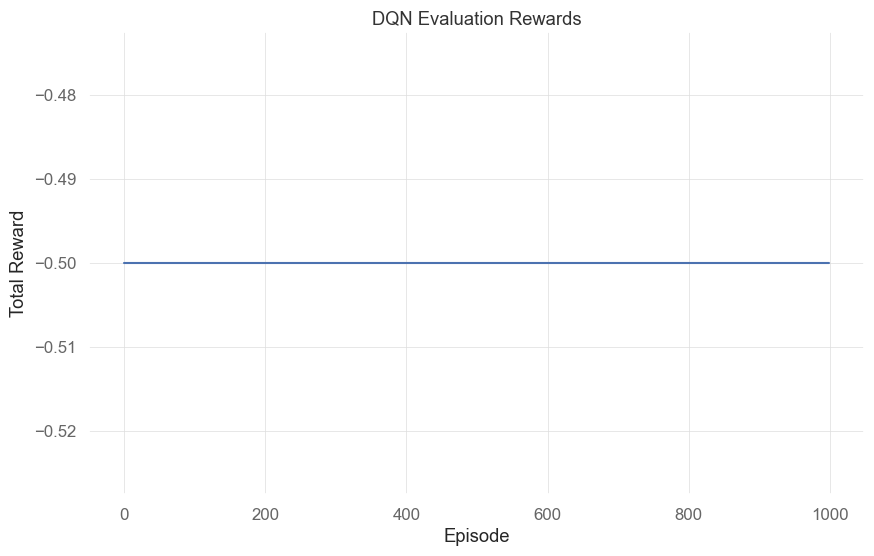

In [ ]:

# Plot the evaluation rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Evaluation Rewards')
plt.grid(True)
plt.show()
